In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from platform import python_version

print(python_version())

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.applications import DenseNet121,InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
# Specific neural network models & layer types
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

3.10.14


In [5]:
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.16.2


In [6]:
# Path to Images Dataset Images
Images_path_part1 = '/Users/darylwanji/Desktop/Computer_Vision_Capstone_Project/data/HAM10000_images_part_1'
Images_path_part2 = '/Users/darylwanji/Desktop/Computer_Vision_Capstone_Project/data/HAM10000_images_part_2'

# Path to All Images in Dataset
final_path = '/Users/darylwanji/Desktop/Computer_Vision_Capstone_Project/data/All_Images'

In [7]:

def copy_image_files(src_folder, dest_folder):
    """
    Copy image files from the source folder to the destination folder.

    Parameters:
    src_folder (str): Path to the source folder containing image files.
    dest_folder (str): Path to the destination folder where image files will be copied.

    Returns:
    None
    """
    for filename in os.listdir(src_folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            shutil.copy(os.path.join(src_folder, filename), dest_folder)

        
# Create the destination folder if it doesn't exist
if not os.path.exists(final_path):
    os.makedirs(final_path)

copy_image_files(Images_path_part1, final_path)
copy_image_files(Images_path_part2, final_path)

In [8]:
meta_data_df = pd.read_csv('/Users/darylwanji/Desktop/Computer_Vision_Capstone_Project/data/Updated_metadata.csv')
meta_data_df.sample(5)

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path
8830,HAM_0003902,ISIC_0030313,nv,histo,30,male,lower extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...
8020,HAM_0006295,ISIC_0033177,nv,histo,25,female,back,/Users/darylwanji/Desktop/Computer_Vision_Caps...
4680,HAM_0006336,ISIC_0032117,nv,follow_up,55,female,abdomen,/Users/darylwanji/Desktop/Computer_Vision_Caps...
1789,HAM_0006802,ISIC_0032887,mel,histo,40,male,upper extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...
8562,HAM_0006086,ISIC_0025563,nv,histo,35,female,hand,/Users/darylwanji/Desktop/Computer_Vision_Caps...


In [9]:
# Add Images' Path to Metadata
meta_data_df['Image_path'] = meta_data_df['image_id'].apply(lambda x: os.path.join(final_path, f"{x}.jpg"))
#Save Meta Data to new file
meta_data_df.to_csv('/Users/darylwanji/Desktop/Computer_Vision_Capstone_Project/data/Updated_metadata.csv',index=False)

In [10]:
meta_data_df

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80,male,scalp,/Users/darylwanji/Desktop/Computer_Vision_Caps...
1,HAM_0000118,ISIC_0025030,bkl,histo,80,male,scalp,/Users/darylwanji/Desktop/Computer_Vision_Caps...
2,HAM_0002730,ISIC_0026769,bkl,histo,80,male,scalp,/Users/darylwanji/Desktop/Computer_Vision_Caps...
3,HAM_0002730,ISIC_0025661,bkl,histo,80,male,scalp,/Users/darylwanji/Desktop/Computer_Vision_Caps...
4,HAM_0001466,ISIC_0031633,bkl,histo,75,male,ear,/Users/darylwanji/Desktop/Computer_Vision_Caps...
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40,male,abdomen,/Users/darylwanji/Desktop/Computer_Vision_Caps...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40,male,abdomen,/Users/darylwanji/Desktop/Computer_Vision_Caps...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40,male,abdomen,/Users/darylwanji/Desktop/Computer_Vision_Caps...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80,male,face,/Users/darylwanji/Desktop/Computer_Vision_Caps...


In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
meta_data_df['Updated_Diagnosis_Label'] = label_encoder.fit_transform(meta_data_df['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [12]:
meta_data_df.sample(5)

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path,Updated_Diagnosis_Label
1842,HAM_0006517,ISIC_0032672,mel,histo,55,female,lower extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,4
5798,HAM_0004906,ISIC_0028522,nv,follow_up,35,male,lower extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
9244,HAM_0001169,ISIC_0029328,nv,consensus,10,male,upper extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
3119,HAM_0000797,ISIC_0026039,nv,follow_up,50,female,lower extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
1771,HAM_0001272,ISIC_0032968,mel,histo,85,male,upper extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,4


# Base Model 
This Model will be done without working on the Class Imbalance

In [13]:
# Shuffle Dataset 
meta_data_df = meta_data_df.sample(frac=1, random_state=42).reset_index(drop=True)
meta_data_df

,lesion_id,image_id,Diagnosis,Confirmation_Method,Age,Sex,Location,Image_path,Updated_Diagnosis_Label
0,HAM_0007180,ISIC_0033272,mel,histo,65,male,face,/Users/darylwanji/Desktop/Computer_Vision_Caps...,4
1,HAM_0007195,ISIC_0031923,nv,histo,40,female,lower extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
2,HAM_0001835,ISIC_0026652,mel,histo,65,male,back,/Users/darylwanji/Desktop/Computer_Vision_Caps...,4
3,HAM_0000465,ISIC_0030583,bkl,consensus,35,female,trunk,/Users/darylwanji/Desktop/Computer_Vision_Caps...,2
4,HAM_0001720,ISIC_0034010,nv,histo,45,male,abdomen,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
...,...,...,...,...,...,...,...,...,...
10010,HAM_0005460,ISIC_0028199,nv,follow_up,50,female,lower extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
10011,HAM_0005615,ISIC_0031067,nv,follow_up,45,female,trunk,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
10012,HAM_0005773,ISIC_0031096,nv,follow_up,45,female,lower extremity,/Users/darylwanji/Desktop/Computer_Vision_Caps...,5
10013,HAM_0001053,ISIC_0030998,bkl,consensus,55,female,chest,/Users/darylwanji/Desktop/Computer_Vision_Caps...,2


In [14]:
# Sample Dataset
Sample_Meta_data_df = meta_data_df.sample(n=500,random_state=42)

In [15]:

# Separate features (X) and target variable (y)
X = Sample_Meta_data_df.drop(columns=['Updated_Diagnosis_Label']) 
y = Sample_Meta_data_df['Updated_Diagnosis_Label']

# Display the shape of X and y
print("Shape of features (X):", X.shape)
print("Shape of target variable (y):", y.shape)

Shape of features (X): (500, 8)
Shape of target variable (y): (500,)


In [16]:
#train-test split without stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
# To visualize  Class Labels
viz_datagen = ImageDataGenerator(rescale=1./255)
viz_generator = viz_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)


Found 280 validated image filenames belonging to 7 classes.


[5 5 4 5 5 5 5 5 4 2 5 6 5 5 5 4 5 5 5 5 5 1 6 1 5 2 5 5 6 5 5 5]


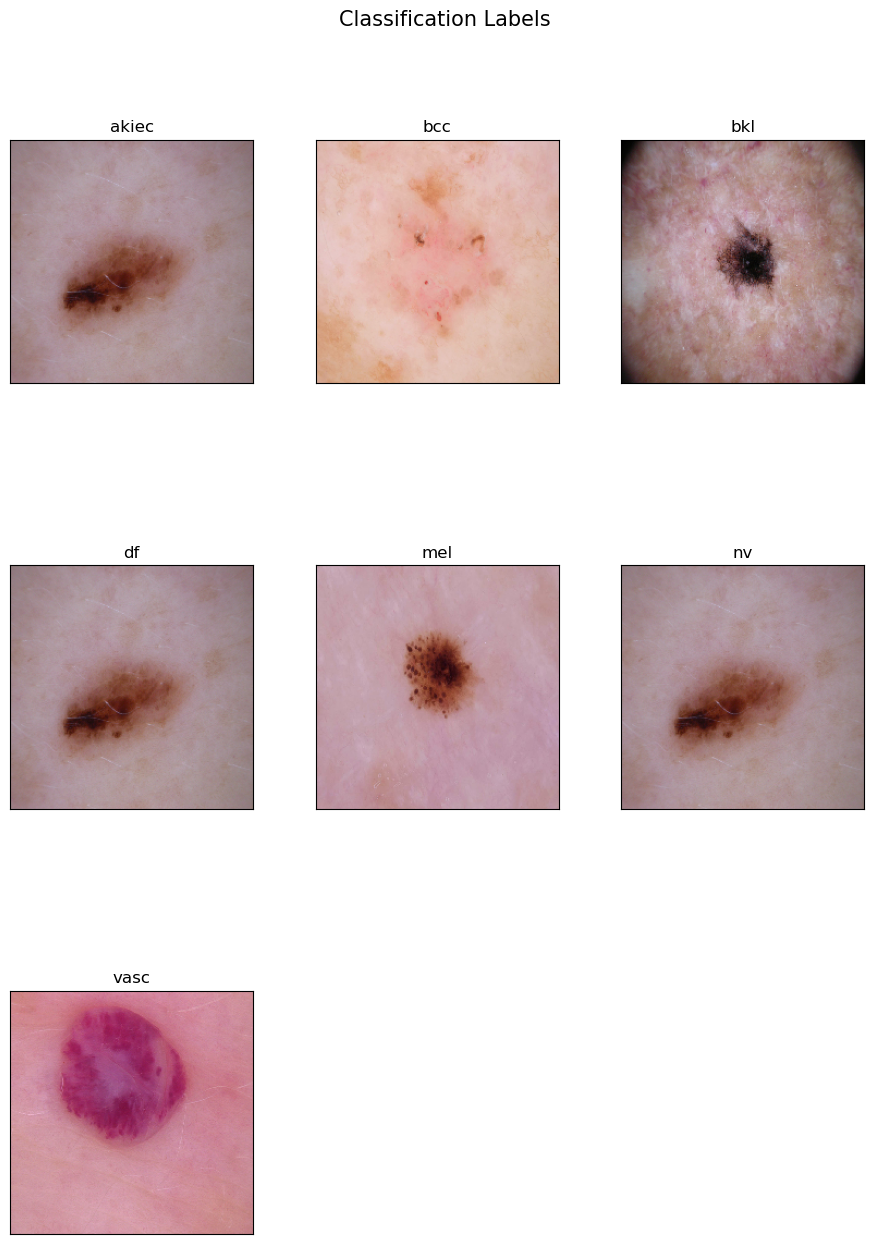

In [18]:
# Grab a batch of images from our validation generator:
x_1, y_1 = next(viz_generator)
# Our images labels are one-hot encoded, lets
# convert them to ordinal encoding
labels = np.argmax(y_1, axis=1)
print(labels)
diagnosis_ = [
    'akiec',
    'bcc',
    'bkl',
    'df',
    'mel',
    'nv',
    'vasc'
]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 14))
ax = ax.flatten()

for i in range(7):
    index = np.argmax(labels==i)
    ax[i].imshow(x_1[index])

    # Set the title of the subplot
    ax[i].set_title(diagnosis_[i])

    # Hide the x and y ticks
    ax[i].set_xticks([])
    ax[i].set_yticks([])


fig.suptitle("Classification Labels", size = 15)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

plt.show()

In [19]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
rescale=1./255,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=X_val,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    x_col='Image_path',
    y_col='Diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 280 validated image filenames belonging to 7 classes.
Found 70 validated image filenames belonging to 6 classes.
Found 150 validated image filenames belonging to 6 classes.


### ResNet-50


In [20]:
import random

def set_random_seed(seed):

    '''Random seeds for reproducability'''

    random.seed(seed)
    tf.random.set_seed(seed)

In [21]:
from tensorflow.keras.applications import ResNet50V2

height = 224
width = 224
channels = 3

res_model = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))
res_model.summary()

2024-07-05 13:03:17.656326: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-05 13:03:17.656346: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-05 13:03:17.656355: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-05 13:03:17.656395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-05 13:03:17.656410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [22]:
# Freeze all the layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras.models import Model
#daisy chain, the output of one layer becomes the input of another via function arg

set_random_seed(121)
x = res_model.output
flattened = Flatten()(x)
dense1 = Dense(128, activation='relu')(flattened)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(7, activation='softmax')(dense2)


# Model 
model = Model(inputs=res_model.input,
              outputs=output)

: 

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

set_random_seed(121)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)
model.fit(train_generator,
          epochs=10,
          validation_data = val_generator,
          callbacks=[early_stop])

Epoch 1/10


In [ ]:
X_test , y_test = next(test_generator)

# Evaluate the model's performance on the test data
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
# Calculate the predictions
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (8,6))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=diagnosis_,
            yticklabels=diagnosis_,
            cmap="rocket_r",
            linewidths=1,

           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()